# Fake News Detection using Machine Learning and Models


In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import time

## Step 1: Load Dataset
We read the CSV file and skip bad lines if any. Also, we drop the `Unnamed: 0` column if it exists.

In [2]:
print("Loading dataset...")
try:
    df = pd.read_csv('news.csv', on_bad_lines='skip')
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Drop unnamed column if exists
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Combine title and text
df['full_text'] = df['title'] + ' ' + df['text']
print("'full_text' column created.")

if 'label' not in df.columns:
    print("Error: 'label' column not found in the dataset.")
    exit()

Loading dataset...
Dataset loaded successfully.
'full_text' column created.


## Step 2: Download NLTK Resources
Download all required NLTK tokenizers

In [3]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

## Step 3: Text Preprocessing
We lemmatize, lowercase, remove stopwords and punctuation, and tokenize the combined text column.

In [4]:
print("Starting text preprocessing...")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sentence_tokenizer = nltk.PunktSentenceTokenizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = []
    for sentence in sentence_tokenizer.tokenize(text):
        tokens.extend(nltk.word_tokenize(sentence))
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(lemmatized_tokens)

df['processed_text'] = df['full_text'].apply(preprocess_text)
print("Text preprocessing complete.")

Starting text preprocessing...
Text preprocessing complete.


## Step 4: TF-IDF Vectorization and Train-Test Split
We transform the processed text using TF-IDF and then split the data for training and testing.

In [5]:
print("Performing TF-IDF Vectorization and data splitting...")
X = df['processed_text']
y = df['label']

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of training features: {X_train.shape}")
print(f"Shape of testing features: {X_test.shape}")

Performing TF-IDF Vectorization and data splitting...
Shape of training features: (5068, 5000)
Shape of testing features: (1267, 5000)


## Step 5: Multinomial Naive Bayes
Train and evaluate a MultinomialNB classifier.


--- Multinomial Naive Bayes ---
Training Time: 0.1794295310974121 seconds
Prediction Time: 0.029240131378173828 seconds
Accuracy: 0.8768745067087609
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.86      0.89      0.88       633
        REAL       0.89      0.86      0.87       634

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267



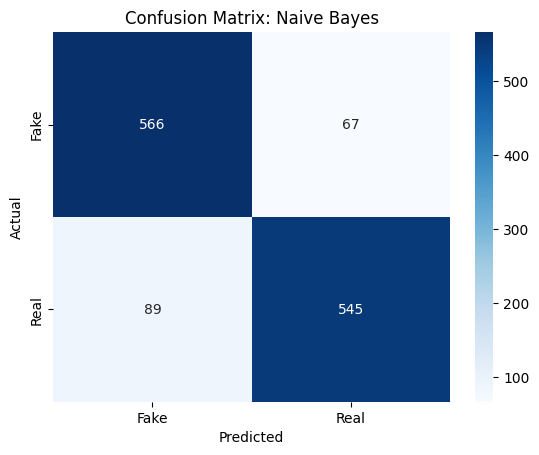

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Multinomial Naive Bayes ---")
start_time = time.time()
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time, "seconds")

start_time = time.time()
y_pred_nb = nb_model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time, "seconds")

print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix: Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Step 6: K-Nearest Neighbors
Train and evaluate a KNN classifier with `n_neighbors = 5`.


--- K-Nearest Neighbors ---
Training Time: 0.023375749588012695 seconds
Prediction Time: 4.339809417724609 seconds
Accuracy: 0.8721389108129439
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.90      0.84      0.87       633
        REAL       0.85      0.91      0.88       634

    accuracy                           0.87      1267
   macro avg       0.87      0.87      0.87      1267
weighted avg       0.87      0.87      0.87      1267



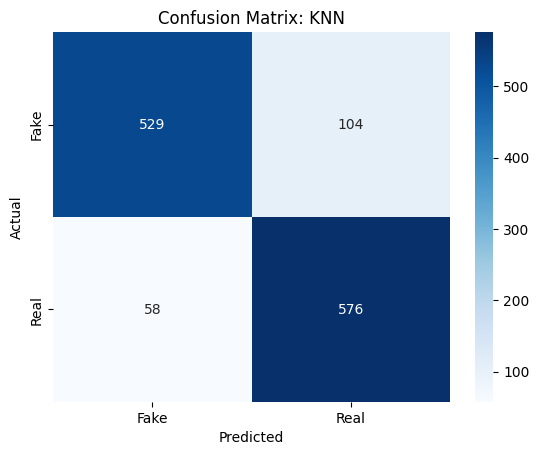

In [7]:
from sklearn.neighbors import KNeighborsClassifier

print("\n--- K-Nearest Neighbors ---")
start_time = time.time()
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time, "seconds")

start_time = time.time()
y_pred_knn = knn_model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time, "seconds")

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix: KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Step 7: Logistic Regression
Train and evaluate a logistic regression classifier.


--- Logistic Regression ---
Training Time: 2.16597580909729 seconds
Prediction Time: 0.020837068557739258 seconds
Accuracy: 0.914759273875296
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.89      0.94      0.92       633
        REAL       0.94      0.89      0.91       634

    accuracy                           0.91      1267
   macro avg       0.92      0.91      0.91      1267
weighted avg       0.92      0.91      0.91      1267



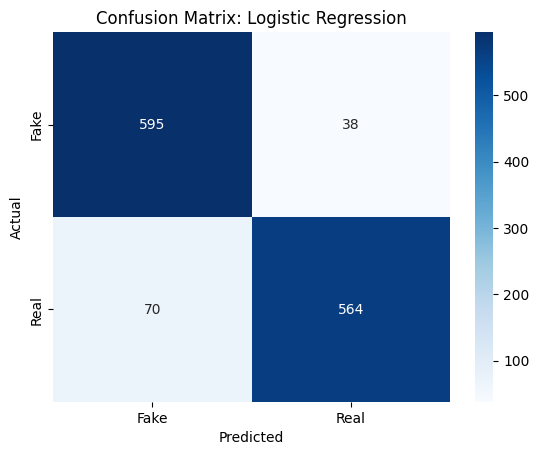

In [9]:
from sklearn.linear_model import LogisticRegression

print("\n--- Logistic Regression ---")
start_time = time.time()
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time, "seconds")

start_time = time.time()
y_pred_lr = lr_model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time, "seconds")

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Step 8: Support Vector Machine (SVM)
Train and evaluate a linear kernel SVM classifier.


--- Support Vector Machine ---
Training Time: 54.14640259742737 seconds
Prediction Time: 9.762370109558105 seconds
Accuracy: 0.9281767955801105
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93       633
        REAL       0.94      0.91      0.93       634

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



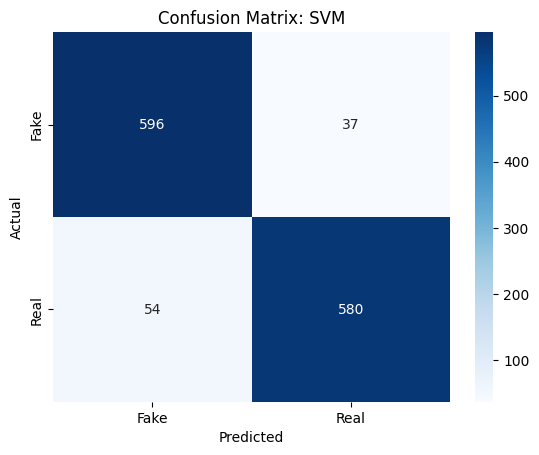

In [10]:
from sklearn.svm import SVC

print("\n--- Support Vector Machine ---")
start_time = time.time()
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time, "seconds")

start_time = time.time()
y_pred_svm = svm_model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time, "seconds")

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix: SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Step 9: Feed Forward Neural Network
Train and evaluate a basic neural network using TensorFlow/Keras.


--- Feed Forward Neural Network ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6953 - loss: 0.6122 - val_accuracy: 0.9073 - val_loss: 0.2296
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9360 - loss: 0.1940 - val_accuracy: 0.9142 - val_loss: 0.1995
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9737 - loss: 0.0883 - val_accuracy: 0.9280 - val_loss: 0.1897
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9926 - loss: 0.0394 - val_accuracy: 0.9310 - val_loss: 0.2135
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9970 - loss: 0.0195 - val_accuracy: 0.9260 - val_loss: 0.2371
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9976 - loss: 0.0128 - val_accuracy: 0.9280 - val_loss: 0.2653
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9990 - loss: 0.0078 - val_accuracy: 0.9241 - val_loss: 0.2843
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accu

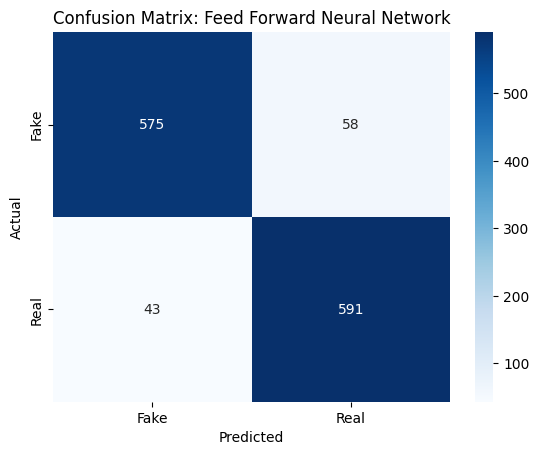

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

print("\n--- Feed Forward Neural Network ---")

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

y_train_numeric = y_train.apply(lambda x: 1 if x == 'REAL' else 0)
y_test_numeric = y_test.apply(lambda x: 1 if x == 'REAL' else 0)

start_time = time.time()
history = model.fit(X_train, y_train_numeric, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
end_time = time.time()
print("Training Time:", end_time - start_time, "seconds")

loss, accuracy = model.evaluate(X_test, y_test_numeric, verbose=0)
print(f"Test Accuracy: {accuracy}")

start_time = time.time()
y_pred_nn_proba = model.predict(X_test)
y_pred_nn = (y_pred_nn_proba > 0.5).astype("int").flatten()
end_time = time.time()
print("Prediction Time:", end_time - start_time, "seconds")

y_pred_nn_labels = ['REAL' if pred == 1 else 'FAKE' for pred in y_pred_nn]

print("Classification Report:\n", classification_report(y_test, y_pred_nn_labels))

cm_nn = confusion_matrix(y_test, y_pred_nn_labels)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix: Feed Forward Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()